In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

In [15]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import data

In [16]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


# Scalling

In [48]:
df.Temp = df.Temp.transform(lambda x: (x- x.mean()/x.std()))

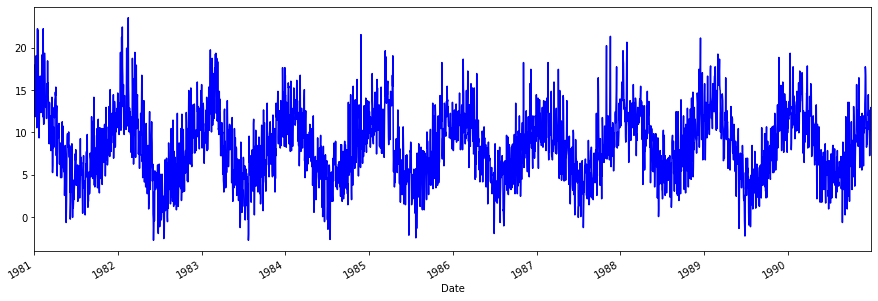

In [49]:
df.Temp.plot(figsize=(15,5), color = "b")

# Dataset Spliting

In [50]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset dan dataloader

In [51]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader 

In [52]:
seq_len = 21
bs = 32

train_set = TimeSeriesDataset(ts_train,"Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test,"Temp",seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (139, 21, 5)
Note: last 0 data excluded

(N, S, F): (34, 21, 5)
Note: last 15 data excluded



# Arsitektur dan config

In [53]:
class GRU(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout = dropout, batch_first =True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x , hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [54]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation

In [55]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduce="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

# Training

In [56]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 80.3849 | Test_cost  = 75.8359 | 




Epoch     2
Train_cost  = 66.2986 | Test_cost  = 61.9364 | 




Epoch     3
Train_cost  = 53.4632 | Test_cost  = 49.6354 | 




Epoch     4
Train_cost  = 42.6491 | Test_cost  = 40.5344 | 




Epoch     5
Train_cost  = 35.0824 | Test_cost  = 34.6542 | 




Epoch     6
Train_cost  = 30.2647 | Test_cost  = 30.7669 | 




Epoch     7
Train_cost  = 27.0303 | Test_cost  = 27.9241 | 




Epoch     8
Train_cost  = 24.6356 | Test_cost  = 25.6976 | 




Epoch     9
Train_cost  = 22.7640 | Test_cost  = 23.9093 | 




Epoch    10
Train_cost  = 21.2768 | Test_cost  = 22.4665 | 




Epoch    11
Train_cost  = 20.0956 | Test_cost  = 21.3072 | 




Epoch    12
Train_cost  = 19.1647 | Test_cost  = 20.3824 | 




Epoch    13
Train_cost  = 18.4385 | Test_cost  = 19.6506 | 




Epoch    14
Train_cost  = 17.8781 | Test_cost  = 19.0757 | 




Epoch    15
Train_cost  = 17.4498 | Test_cost  = 18.6266 | 




Epoch    16
Train_cost  = 17.1250 | Test_cost  = 18.2768 | 




Epoch    17
Train_cost  = 16.8791 | Test_cost  = 18.0037 | 




Epoch    18
Train_cost  = 16.6919 | Test_cost  = 17.7882 | 




Epoch    19
Train_cost  = 16.5462 | Test_cost  = 17.6140 | 




Epoch    20
Train_cost  = 16.4275 | Test_cost  = 17.4668 | 


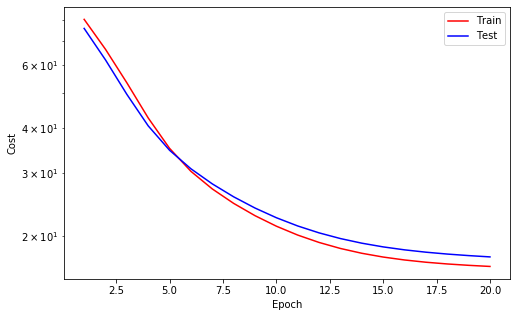



Epoch    21
Train_cost  = 16.3230 | Test_cost  = 17.3333 | 




Epoch    22
Train_cost  = 16.2203 | Test_cost  = 17.1991 | 




Epoch    23
Train_cost  = 16.1053 | Test_cost  = 17.0461 | 




Epoch    24
Train_cost  = 15.9587 | Test_cost  = 16.8473 | 




Epoch    25
Train_cost  = 15.7498 | Test_cost  = 16.5617 | 




Epoch    26
Train_cost  = 15.4325 | Test_cost  = 16.1350 | 




Epoch    27
Train_cost  = 14.9524 | Test_cost  = 15.5403 | 




Epoch    28
Train_cost  = 14.3064 | Test_cost  = 14.7846 | 




Epoch    29
Train_cost  = 13.5119 | Test_cost  = 13.9595 | 




Epoch    30
Train_cost  = 12.8116 | Test_cost  = 13.3316 | 




Epoch    31
Train_cost  = 12.2484 | Test_cost  = 12.6366 | 




Epoch    32
Train_cost  = 11.6754 | Test_cost  = 12.0613 | 




Epoch    33
Train_cost  = 11.2181 | Test_cost  = 11.5137 | 




Epoch    34
Train_cost  = 10.7686 | Test_cost  = 10.9710 | 




Epoch    35
Train_cost  = 10.3427 | Test_cost  = 10.4660 | 




Epoch    36
Train_cost  = 9.9383 | Test_cost  = 9.9863 | 




Epoch    37
Train_cost  = 9.5686 | Test_cost  = 9.5486 | 




Epoch    38
Train_cost  = 9.2348 | Test_cost  = 9.1459 | 




Epoch    39
Train_cost  = 8.9231 | Test_cost  = 8.7639 | 




Epoch    40
Train_cost  = 8.6355 | Test_cost  = 8.4268 | 


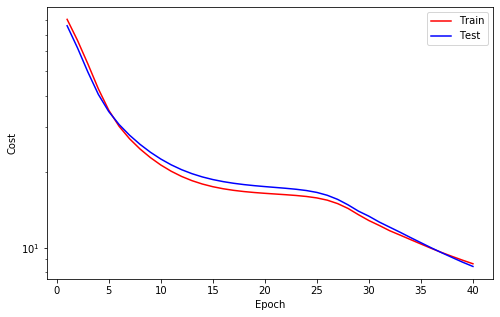



Epoch    41
Train_cost  = 8.3851 | Test_cost  = 8.1393 | 




Epoch    42
Train_cost  = 8.1685 | Test_cost  = 7.8927 | 




Epoch    43
Train_cost  = 7.9844 | Test_cost  = 7.6864 | 




Epoch    44
Train_cost  = 7.8261 | Test_cost  = 7.5067 | 




Epoch    45
Train_cost  = 7.6886 | Test_cost  = 7.3429 | 




Epoch    46
Train_cost  = 7.5664 | Test_cost  = 7.1925 | 




Epoch    47
Train_cost  = 7.4543 | Test_cost  = 7.0545 | 




Epoch    48
Train_cost  = 7.3532 | Test_cost  = 6.9324 | 




Epoch    49
Train_cost  = 7.2618 | Test_cost  = 6.8205 | 




Epoch    50
Train_cost  = 7.1796 | Test_cost  = 6.7171 | 




Epoch    51
Train_cost  = 7.1046 | Test_cost  = 6.6211 | 




Epoch    52
Train_cost  = 7.0361 | Test_cost  = 6.5338 | 




Epoch    53
Train_cost  = 6.9740 | Test_cost  = 6.4540 | 




Epoch    54
Train_cost  = 6.9174 | Test_cost  = 6.3800 | 




Epoch    55
Train_cost  = 6.8654 | Test_cost  = 6.3110 | 




Epoch    56
Train_cost  = 6.8172 | Test_cost  = 6.2475 | 




Epoch    57
Train_cost  = 6.7727 | Test_cost  = 6.1888 | 




Epoch    58
Train_cost  = 6.7314 | Test_cost  = 6.1344 | 




Epoch    59
Train_cost  = 6.6928 | Test_cost  = 6.0830 | 




Epoch    60
Train_cost  = 6.6565 | Test_cost  = 6.0351 | 


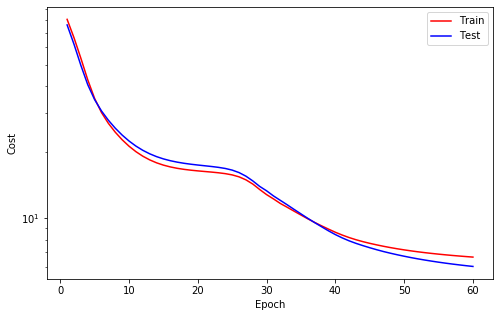



Epoch    61
Train_cost  = 6.6223 | Test_cost  = 5.9899 | 




Epoch    62
Train_cost  = 6.5900 | Test_cost  = 5.9476 | 




Epoch    63
Train_cost  = 6.5593 | Test_cost  = 5.9073 | 




Epoch    64
Train_cost  = 6.5301 | Test_cost  = 5.8693 | 




Epoch    65
Train_cost  = 6.5023 | Test_cost  = 5.8333 | 




Epoch    66
Train_cost  = 6.4759 | Test_cost  = 5.7991 | 




Epoch    67
Train_cost  = 6.4506 | Test_cost  = 5.7665 | 




Epoch    68
Train_cost  = 6.4265 | Test_cost  = 5.7355 | 




Epoch    69
Train_cost  = 6.4034 | Test_cost  = 5.7060 | 




Epoch    70
Train_cost  = 6.3814 | Test_cost  = 5.6780 | 




Epoch    71
Train_cost  = 6.3604 | Test_cost  = 5.6512 | 




Epoch    72
Train_cost  = 6.3402 | Test_cost  = 5.6257 | 




Epoch    73
Train_cost  = 6.3209 | Test_cost  = 5.6014 | 




Epoch    74
Train_cost  = 6.3024 | Test_cost  = 5.5782 | 




Epoch    75
Train_cost  = 6.2846 | Test_cost  = 5.5560 | 




Epoch    76
Train_cost  = 6.2675 | Test_cost  = 5.5348 | 




Epoch    77
Train_cost  = 6.2511 | Test_cost  = 5.5146 | 




Epoch    78
Train_cost  = 6.2353 | Test_cost  = 5.4952 | 




Epoch    79
Train_cost  = 6.2201 | Test_cost  = 5.4765 | 




Epoch    80
Train_cost  = 6.2055 | Test_cost  = 5.4586 | 


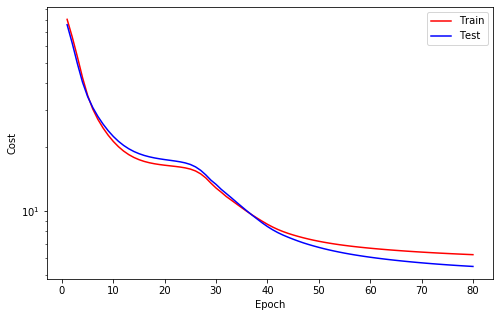



Epoch    81
Train_cost  = 6.1914 | Test_cost  = 5.4414 | 




Epoch    82
Train_cost  = 6.1777 | Test_cost  = 5.4248 | 




Epoch    83
Train_cost  = 6.1646 | Test_cost  = 5.4088 | 




Epoch    84
Train_cost  = 6.1518 | Test_cost  = 5.3934 | 




Epoch    85
Train_cost  = 6.1395 | Test_cost  = 5.3784 | 




Epoch    86
Train_cost  = 6.1275 | Test_cost  = 5.3639 | 




Epoch    87
Train_cost  = 6.1159 | Test_cost  = 5.3499 | 




Epoch    88
Train_cost  = 6.1046 | Test_cost  = 5.3363 | 




Epoch    89
Train_cost  = 6.0936 | Test_cost  = 5.3230 | 




Epoch    90
Train_cost  = 6.0828 | Test_cost  = 5.3102 | 




Epoch    91
Train_cost  = 6.0724 | Test_cost  = 5.2976 | 




Epoch    92
Train_cost  = 6.0621 | Test_cost  = 5.2854 | 




Epoch    93
Train_cost  = 6.0521 | Test_cost  = 5.2736 | 




Epoch    94
Train_cost  = 6.0423 | Test_cost  = 5.2621 | 




Epoch    95
Train_cost  = 6.0327 | Test_cost  = 5.2510 | 




Epoch    96
Train_cost  = 6.0232 | Test_cost  = 5.2403 | 




Epoch    97
Train_cost  = 6.0139 | Test_cost  = 5.2299 | 




Epoch    98
Train_cost  = 6.0048 | Test_cost  = 5.2200 | 




Epoch    99
Train_cost  = 5.9958 | Test_cost  = 5.2104 | 




Epoch   100
Train_cost  = 5.9869 | Test_cost  = 5.2012 | 


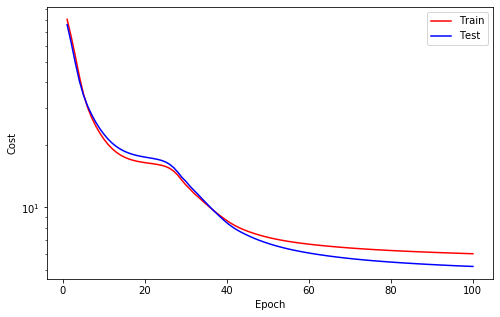



Epoch   101
Train_cost  = 5.9782 | Test_cost  = 5.1923 | 




Epoch   102
Train_cost  = 5.9695 | Test_cost  = 5.1837 | 




Epoch   103
Train_cost  = 5.9610 | Test_cost  = 5.1755 | 




Epoch   104
Train_cost  = 5.9526 | Test_cost  = 5.1675 | 




Epoch   105
Train_cost  = 5.9442 | Test_cost  = 5.1599 | 




Epoch   106
Train_cost  = 5.9360 | Test_cost  = 5.1525 | 




Epoch   107
Train_cost  = 5.9278 | Test_cost  = 5.1453 | 




Epoch   108
Train_cost  = 5.9197 | Test_cost  = 5.1385 | 




Epoch   109
Train_cost  = 5.9117 | Test_cost  = 5.1319 | 




Epoch   110
Train_cost  = 5.9038 | Test_cost  = 5.1256 | 




Epoch   111
Train_cost  = 5.8960 | Test_cost  = 5.1195 | 




Epoch   112
Train_cost  = 5.8883 | Test_cost  = 5.1137 | 




Epoch   113
Train_cost  = 5.8807 | Test_cost  = 5.1082 | 




Epoch   114
Train_cost  = 5.8732 | Test_cost  = 5.1029 | 




Epoch   115
Train_cost  = 5.8659 | Test_cost  = 5.0979 | 




Epoch   116
Train_cost  = 5.8586 | Test_cost  = 5.0932 | 




Epoch   117
Train_cost  = 5.8515 | Test_cost  = 5.0887 | 




Epoch   118
Train_cost  = 5.8444 | Test_cost  = 5.0844 | 




Epoch   119
Train_cost  = 5.8375 | Test_cost  = 5.0805 | 




Epoch   120
Train_cost  = 5.8306 | Test_cost  = 5.0767 | 


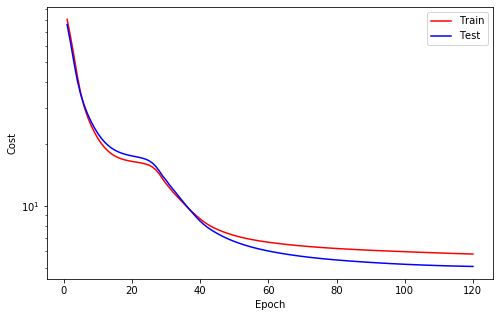



Epoch   121
Train_cost  = 5.8239 | Test_cost  = 5.0732 | 




Epoch   122
Train_cost  = 5.8173 | Test_cost  = 5.0699 | 




Epoch   123
Train_cost  = 5.8107 | Test_cost  = 5.0668 | 




Epoch   124
Train_cost  = 5.8042 | Test_cost  = 5.0638 | 




Epoch   125
Train_cost  = 5.7978 | Test_cost  = 5.0611 | 




Epoch   126
Train_cost  = 5.7915 | Test_cost  = 5.0585 | 




Epoch   127
Train_cost  = 5.7852 | Test_cost  = 5.0560 | 




Epoch   128
Train_cost  = 5.7790 | Test_cost  = 5.0537 | 




Epoch   129
Train_cost  = 5.7728 | Test_cost  = 5.0516 | 




Epoch   130
Train_cost  = 5.7667 | Test_cost  = 5.0495 | 




Epoch   131
Train_cost  = 5.7606 | Test_cost  = 5.0476 | 




Epoch   132
Train_cost  = 5.7546 | Test_cost  = 5.0458 | 




Epoch   133
Train_cost  = 5.7486 | Test_cost  = 5.0441 | 




Epoch   134
Train_cost  = 5.7426 | Test_cost  = 5.0426 | 




Epoch   135
Train_cost  = 5.7367 | Test_cost  = 5.0411 | 




Epoch   136
Train_cost  = 5.7308 | Test_cost  = 5.0397 | 




Epoch   137
Train_cost  = 5.7250 | Test_cost  = 5.0385 | 




Epoch   138
Train_cost  = 5.7191 | Test_cost  = 5.0374 | 




Epoch   139
Train_cost  = 5.7134 | Test_cost  = 5.0363 | 




Epoch   140
Train_cost  = 5.7076 | Test_cost  = 5.0354 | 


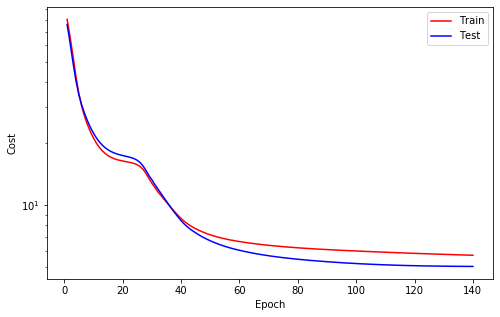



Epoch   141
Train_cost  = 5.7019 | Test_cost  = 5.0347 | 




Epoch   142
Train_cost  = 5.6962 | Test_cost  = 5.0340 | 




Epoch   143
Train_cost  = 5.6905 | Test_cost  = 5.0334 | 




Epoch   144
Train_cost  = 5.6848 | Test_cost  = 5.0330 | 




Epoch   145
Train_cost  = 5.6791 | Test_cost  = 5.0327 | 




Epoch   146
Train_cost  = 5.6734 | Test_cost  = 5.0324 | 




Epoch   147
Train_cost  = 5.6677 | Test_cost  = 5.0323 | 




Epoch   148
Train_cost  = 5.6621 | Test_cost  = 5.0322 | 




Epoch   149
Train_cost  = 5.6564 | Test_cost  = 5.0322 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0322




Epoch   150
Train_cost  = 5.6507 | Test_cost  = 5.0323 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0322




Epoch   151
Train_cost  = 5.6450 | Test_cost  = 5.0326 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0322




Epoch   152
Train_cost  = 5.6393 | Test_cost  = 5.0328 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0322




Epoch   153
Train_cost  = 5.6336 | Test_cost  = 5.0332 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0322
==> Execute Early Stopping at epoch: 153 | Best test_cost: 5.0322
==> Best model is saved at model/multivar


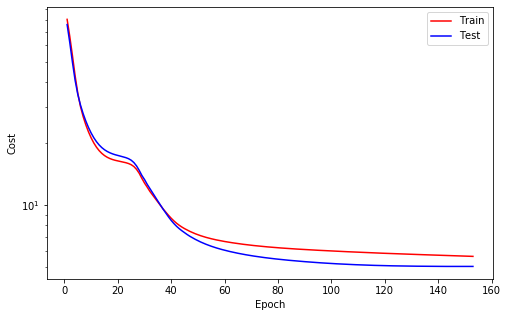

In [57]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [58]:
from luwiji.rnn import illustration

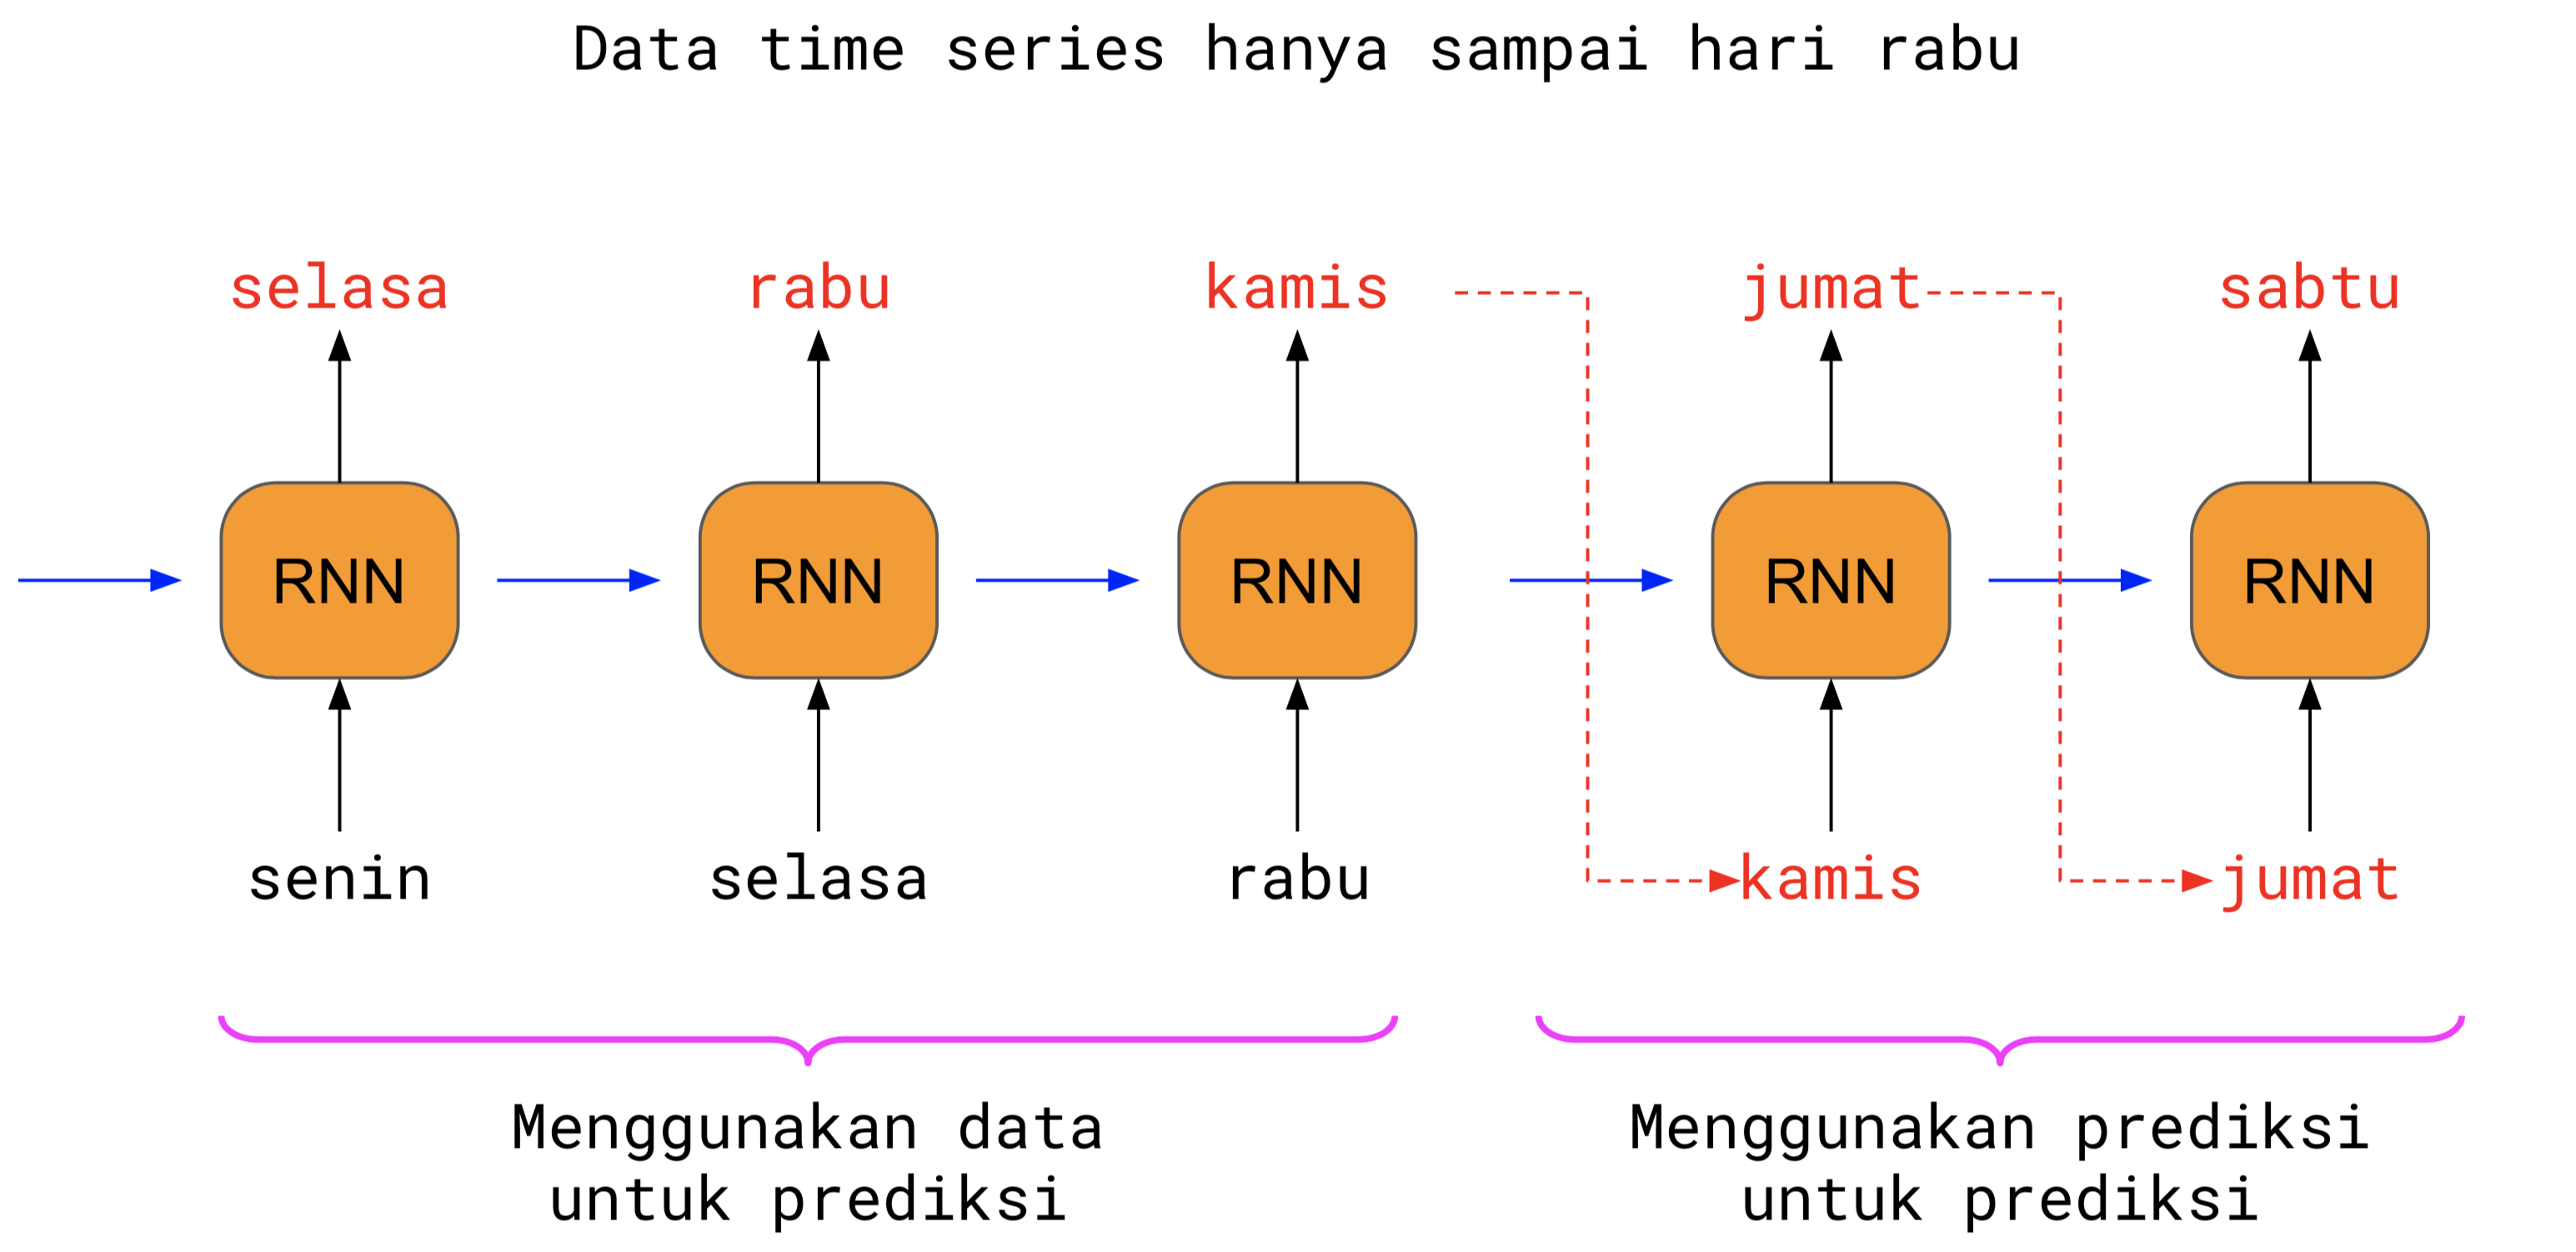

In [59]:
illustration.forecast

In [60]:
from utils import data4pred, pred4pred

In [61]:
train_forecast_set =TimeSeriesDataset(ts_train,"Temp",1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set =TimeSeriesDataset(ts_test,"Temp",1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



# Visualization

Text(0.5, 1.0, 'Test')

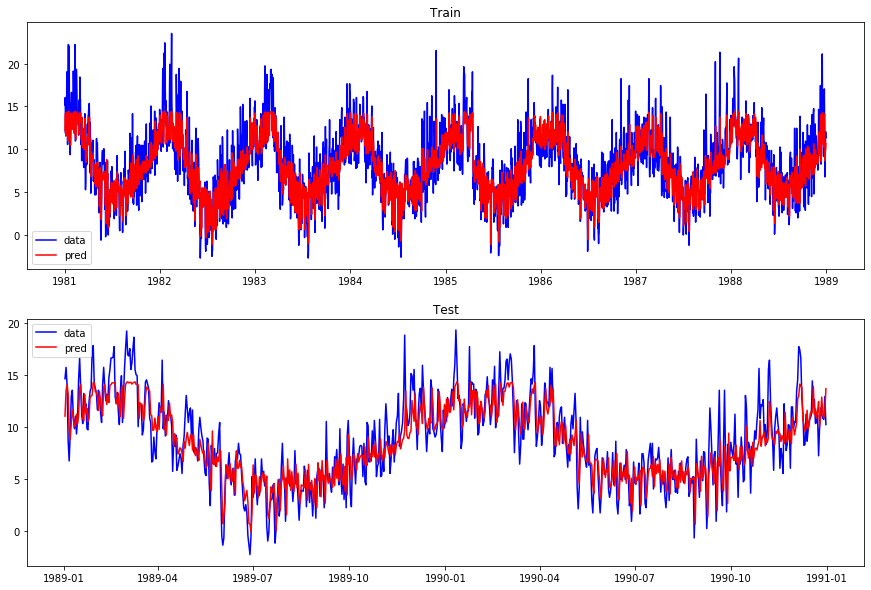

In [62]:
#data 4 pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

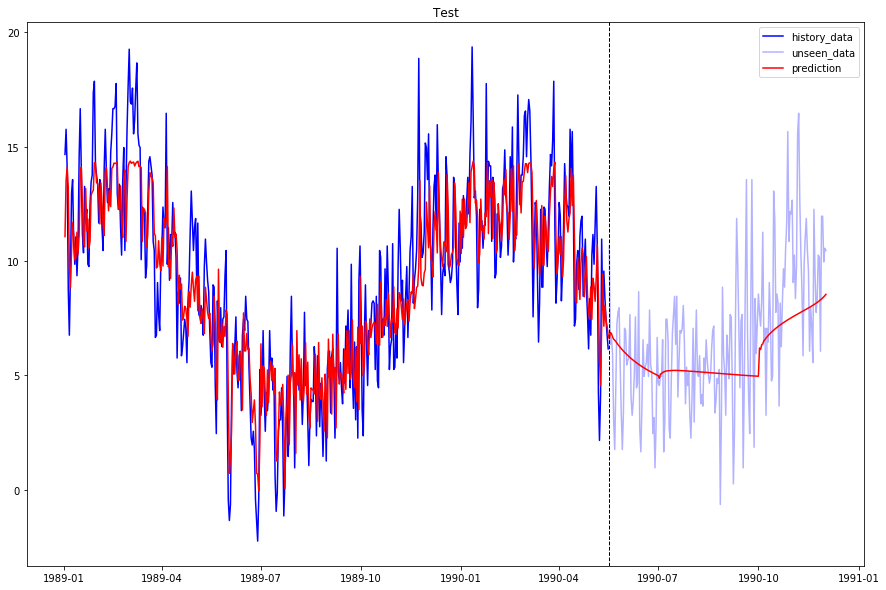

In [63]:
#pred 4 pred
plt.figure(figsize=(15,10))
pred4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")

# More on RNN

In [64]:
from luwiji.rnn import illustration

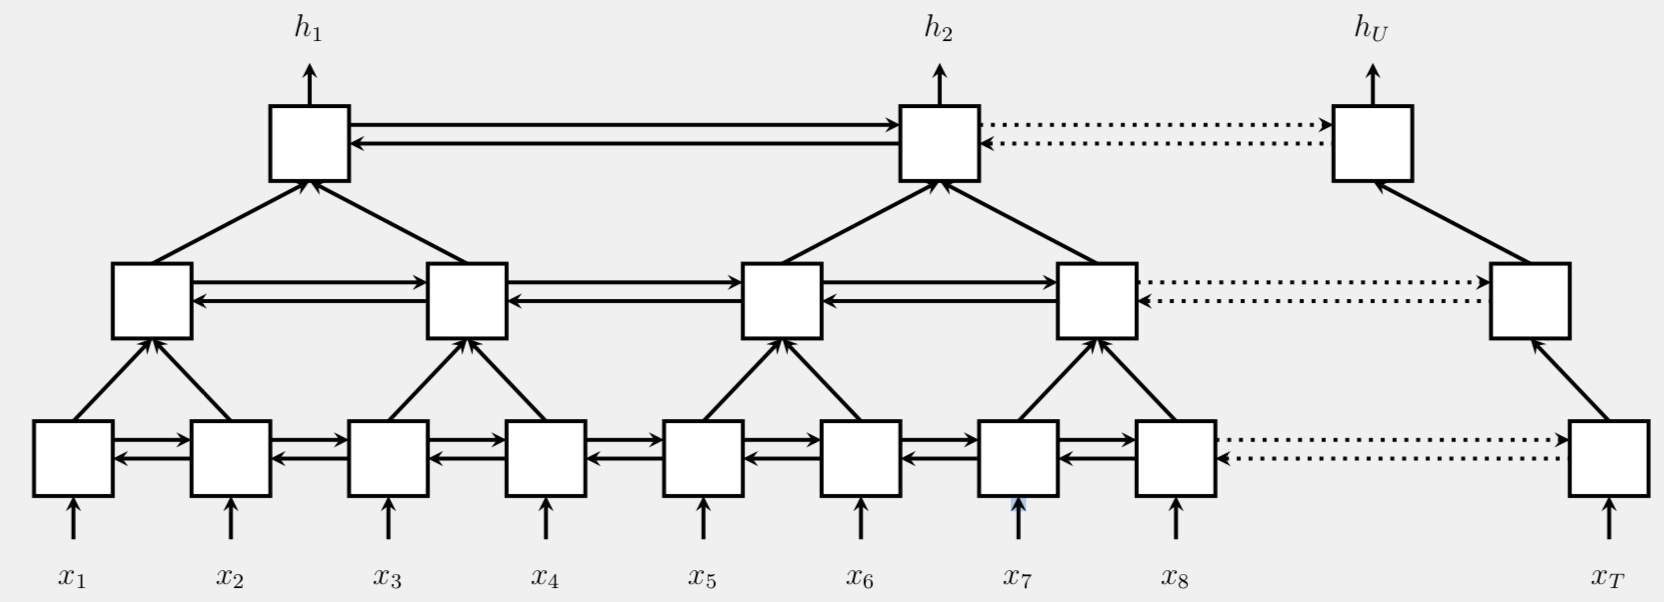

In [65]:
illustration.pyramid_blstm

digunakan untuk speach

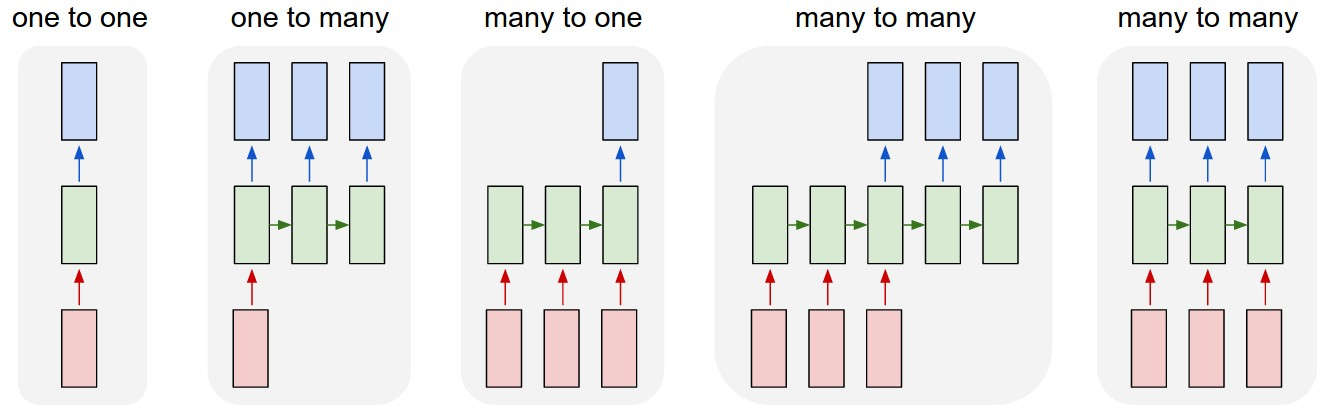

In [66]:
illustration.sequence_model